In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

- characters→識別する文字全種類入っている（ラベルになる）
- 

In [3]:
# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'7', 'b', 'm', '5', 'y', '4', 'e', 'f', 'g', '6', 'p', '2', 'c', 'x', 'd', '3', '8', 'n', 'w'}


In [4]:
labels

['226md',
 '22d5n',
 '2356g',
 '23mdg',
 '23n88',
 '243mm',
 '244e2',
 '245y5',
 '24f6w',
 '24pew',
 '25257',
 '253dc',
 '25egp',
 '25m6p',
 '25p2m',
 '25w53',
 '264m5',
 '268g2',
 '28348',
 '28x47',
 '2b827',
 '2bg48',
 '2cegf',
 '2cg58',
 '2cgyx',
 '2en7g',
 '2enf4',
 '2fxgd',
 '2g783',
 '2g7nm',
 '2gyb6',
 '2mg87',
 '2mpnn',
 '2n73f',
 '2nbcx',
 '2nf26',
 '2npg6',
 '2nx38',
 '2p2y8',
 '2pfpn',
 '2w4y7',
 '2wc38',
 '2wx73',
 '2x7bm',
 '2xc2n',
 '2ycn8',
 '2yggg',
 '325fb',
 '32cnn',
 '32dnn',
 '33b22',
 '33f7m',
 '33n73',
 '33ng4',
 '33p4e',
 '34b84',
 '34fxm',
 '34pcn',
 '368y5',
 '36bc2',
 '36nx4',
 '36w25',
 '373gb',
 '377xx',
 '378e5',
 '37d52',
 '37ep6',
 '387g2',
 '38n57',
 '3b4we',
 '3bd8f',
 '3bfnd',
 '3bnyf',
 '3bx86',
 '3cpwb',
 '3d7bd',
 '3den6',
 '3dgmf',
 '3ebnn',
 '3ebpw',
 '3eny7',
 '3fbxd',
 '3g2w6',
 '3mxdn',
 '3n2b4',
 '3n3cf',
 '3n7mx',
 '3ndxd',
 '3nfdn',
 '3nnpw',
 '3nw7w',
 '3ny45',
 '3p4nn',
 '3p67n',
 '3pe4g',
 '3w2bw',
 '3wnd3',
 '3x325',
 '3x5fm',
 '3xcgg',


# 前処理

In [5]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [6]:
y_train

array(['nmw46', '56ncx', '5x7x5', 'fpw76', 'xnfx5', '5np4m', 'gw468',
       '5mgn4', '6bdn5', '63824', 'mmy5n', '4d22m', 'mgdwb', '5mnpd',
       '6p2ge', 'fbp2c', 'g7gnf', 'yxd7m', '8y63f', 'nfcb5', '57gnx',
       '3ebnn', '4w76g', '6n6gg', 'cx3wg', 'pg4bf', 'bcwnn', '3fbxd',
       'p2dw7', '5pm6b', 'gy5bf', 'bmxpe', '8g4yp', '2npg6', '7gp47',
       '8n5p3', 'nfd8g', '8cm46', 'dyp7n', '6mege', 'b5dn4', '4w6mw',
       'y4ec2', 'fyfbn', 'x8xnp', '4433m', 'yw7ny', '7w67m', 'm67b3',
       'ypw3d', '77387', 'x37bf', 'mbp2y', '3nw7w', 'bbymy', '3bnyf',
       '5ng6e', '3n7mx', 'dcnp8', 'p5nce', '3dgmf', 'ygenn', '7bwm2',
       'yyn57', 'dbny3', '5fyem', 'wmpmp', 'nnfx3', 'nxxf8', 'yd38e',
       '5bnd7', 'ef4mn', '84w7x', 'mwdf6', '6e2dg', 'byfgn', '664dn',
       'ewnx8', 'nbwpn', 'mxyxw', '2356g', '8gecm', '25m6p', '8eggg',
       'pp546', 'dmx8p', '7wyp4', 'cfn53', 'ne325', 'f6ne5', '8wy7d',
       '53mn8', '5ywwf', 'dd764', 'dmw8n', '677g3', 'nnn5p', 'x76mn',
       'w6pxy', '7cg

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

tf.Tensor(
[[17  2 18  5  9]
 [ 3  9 17 12 13]
 [ 3 13  0 13  3]
 [ 7 10 18  0  9]
 [13 17  7 13  3]
 [ 3 17 10  5  2]
 [ 8 18  5  9 16]
 [ 3  2  8 17  5]
 [ 9  1 14 17  3]
 [ 9 15 16 11  5]
 [ 2  2  4  3 17]
 [ 5 14 11 11  2]
 [ 2  8 14 18  1]
 [ 3  2 17 10 14]
 [ 9 10 11  8  6]
 [ 7  1 10 11 12]], shape=(16, 5), dtype=int64)
nmw46
56ncx
5x7x5
fpw76
xnfx5
5np4m
gw468
5mgn4
6bdn5
63824
mmy5n
4d22m
mgdwb
5mnpd
6p2ge
fbp2c


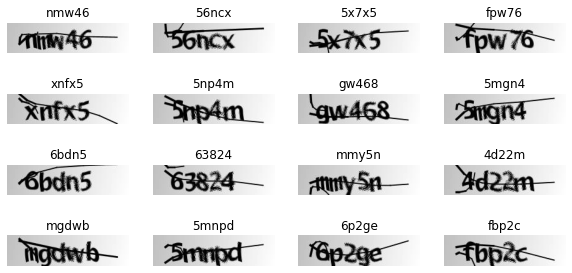

In [10]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    print(labels)
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        print(label)
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# モデル

In [9]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

# トレーニング

In [10]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 11s 192ms/step - loss: 21.7959 - val_loss: 16.3229
Epoch 2/100
59/59 [==============================] - 10s 165ms/step - loss: 16.3435 - val_loss: 16.3058
Epoch 3/100
59/59 [==============================] - 10s 173ms/step - loss: 16.3373 - val_loss: 16.3123
Epoch 4/100
59/59 [==============================] - 10s 166ms/step - loss: 16.3362 - val_loss: 16.3221
Epoch 5/100
59/59 [==============================] - 10s 162ms/step - loss: 16.3324 - val_loss: 16.3198
Epoch 6/100
59/59 [==============================] - 9s 154ms/step - loss: 16.3288 - val_loss: 16.3125
Epoch 7/100
59/59 [==============================] - 10s 177ms/step - loss: 16.3193 - val_loss: 16.3065
Epoch 8/100
59/59 [==============================] - 14s 239ms/step - loss: 16.3024 - val_loss: 16.3078
Epoch 9/100
59/59 [==============================] - 11s 183ms/step - loss: 16.2725 - val_loss: 16.2530
Epoch 10/100
59/59 [==============================] - 12s 201ms/s

KeyboardInterrupt: 